In [40]:
import random
import matplotlib.pyplot as plt

S = 0
I = 1
R = 2

# TODOS: SCHEDULE
# Location indexed by time probably an array

# Locations should be randomly generated and have ID's

# Major based sheduling?

# Should we model parties?

# THESE LATER
VACCINATED = 3
DEAD = 4

class Location:
    def __init__(self, infection_rate):
        self.infection_rate = infection_rate

class Person:
    def __init__(self, location, state=S):
        self.location = location
        self.state = state
        self.recovery_prob = 0.1

def pairs(lst):
    for i, item1 in enumerate(lst):
        for item2 in lst[i+1:]:
            yield item1, item2

def infection_pairs(people):
    for person1, person2 in pairs(people):
        if person1.location == person2.location:
            if person1.state == I and person2.state == S:
                yield person1, person2
            elif person2.state == I and person1.state == S:
                yield person2, person1
                
def find_new_infections(people):
    new_infections = []
    for person1, person2 in infection_pairs(people):
        if random.random() < person1.location.infection_rate and person2 not in new_infections:
            new_infections.append(person2)
    return new_infections

def count_state(people, state):
    return sum(1 for person in people if person.state == state)

def simulate(people, locations, num_days):
    infected = [count_state(people, I)]
    recovered = [count_state(people, R)]
    susceptible = [count_state(people, S)]
    for day in range(num_days):
        # Infection
        for person in find_new_infections(people):
            person.state = I
        # Recovery
        for person in people:
            if person.state == I and random.random() < person.recovery_prob:
                person.state = R
        # Track number of infected people
        infected.append(count_state(people, I))
        recovered.append(count_state(people, R))
        susceptible.append(count_state(people, S))

    return infected, recovered, susceptible


Text(0.5, 0, 'Days')

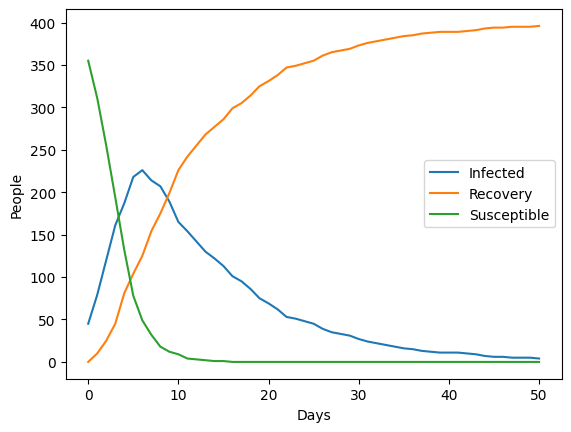

In [43]:
locations = [Location(0.0135), Location(0.0134), Location(0.0132), Location(0.0136), Location(0.021)]
# people = [Person(locations[0], I), Person(locations[0])]

# In our initial model people got infected really fast but recovered really fast
ppl = []
for i in range(400):
    loc = i % 5
    status = random.choices([I, S], weights=[1,7])
    person = Person(locations[loc], status[0])
    ppl.append(person)
    

num_days = 50
i, r, s = simulate(ppl, locations, num_days)

fig, ax = plt.subplots()
ax.plot(i)
ax.plot(r)
ax.plot(s)

ax.legend(["Infected", "Recovery", "Susceptible"])
ax.set_ylabel("People")
ax.set_xlabel("Days")